In [ ]:
# in model.py (or wherever)
import torch.nn as nn
import torch

In [ ]:
# Colab Cell 1 — Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class SimpleCNNEncoder(nn.Module):
    def __init__(self, in_channels=1, out_channels=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.encoder(x)

In [ ]:
class Attention(nn.Module):
    """
    Simple attention mechanism over time dimension.
    Input: x of shape (B, T, hidden_dim)
    Output: context vector of shape (B, hidden_dim)
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x: (B, T, hidden_dim)
        weights = self.attn(x)          # (B, T, 1)
        weights = self.softmax(weights) # (B, T, 1)
        context = torch.sum(weights * x, dim=1)  # (B, hidden_dim)
        return context


In [ ]:
class UAVNavigationModel(nn.Module):
    def __init__(self,
                 num_classes:  int   = 9,
                 hidden_dim:   int   = 256,
                 encoder_out:  int   = 8,
                 image_size:   tuple = (256, 256),
                 debug:        bool  = False):
        """
        image_size: (H, W) of your raw depth maps
        """
        super().__init__()
        self.debug = debug

        # 1) Encoder replaces FCM
        self.encoder = SimpleCNNEncoder(in_channels=1, out_channels=encoder_out)

        # 2) Convolutional feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(encoder_out,  64, kernel_size=3, padding=1),  # [B,64,H,W]
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                       # [B,64,H/2,W/2]
            nn.Conv2d(64,         128, kernel_size=3, padding=1),  # [B,128,H/2,W/2]
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                       # [B,128,H/4,W/4]
        )

        # 3) Figure out how big the CNN output is (once)
        dummy = torch.zeros(1, encoder_out, *image_size)
        with torch.no_grad():
            feat = self.cnn(dummy)             # shape (1, 128, H/4, W/4)
        cnn_feat_dim = feat.numel()            # 128*(H/4)*(W/4)
        if self.debug:
            print(f"[Init] cnn_feat_dim = {cnn_feat_dim}")

        # 4) LSTM + Attention
        self.lstm      = nn.LSTM(input_size=cnn_feat_dim,
                                 hidden_size=hidden_dim,
                                 batch_first=True)
        self.attention = Attention(hidden_dim)

        # 5) Final classifier
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, 1, H, W)
        returns logits: (B, num_classes)
        """
        # 1) Reshape for encoder: (B*T, 1, H, W)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)


        # 2) Encode (replacing FCM) + CNN
        x = self.encoder(x)    # (B*T, encoder_out, H, W)
        x = self.cnn(x)        # (B*T, 128, H/4, W/4)

        # 3) Restore time dimension and flatten
        x = x.view(B, T, -1)   # (B, T, cnn_feat_dim)

        # 4) LSTM + Attention
        lstm_out, _ = self.lstm(x)            # (B, T, hidden_dim)
        context     = self.attention(lstm_out)  # (B, hidden_dim)

        # 5) Classification
        logits = self.fc(context)             # (B, num_classes)
        if self.debug:
            print(f"[forward] logits.shape = {logits.shape}")

        return logits



In [ ]:
import os, glob, numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class DepthDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.files = sorted(glob.glob(os.path.join(data_dir, "*.npy")))
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        arr = np.load(self.files[idx]).astype(np.float32)  # [H,W]
        if self.transform:
            return self.transform(arr), 0
        else:
            return torch.from_numpy(arr).unsqueeze(0), 0

test_transform = transforms.Compose([
    transforms.ToTensor(),  # adds channel dim
    # transforms.Normalize(mean=[…], std=[…])  # if you used it
])


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Testing

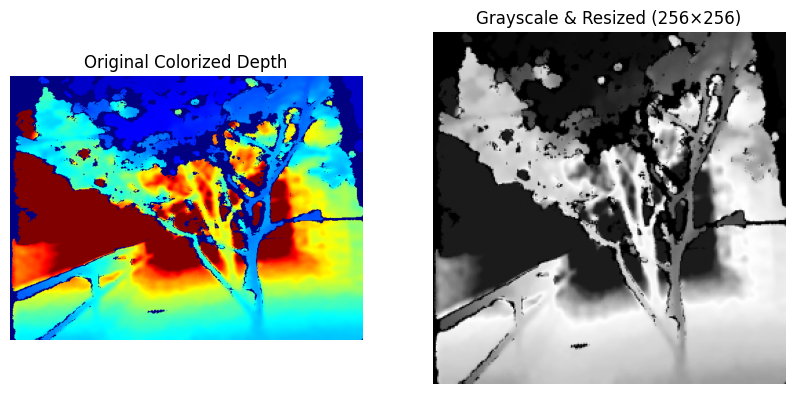

In [ ]:


# Path to your depth-colormap PNG
png_path = "/content/drive/MyDrive/AI Robotic/scenario 1/depth_colormap_20250525_180448.png"

# 1) Load original colorized depth image (BGR → RGB for display)
orig_bgr = cv2.imread(png_path, cv2.IMREAD_COLOR)
orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

# 2) Convert to grayscale & resize to 256×256
gray     = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2GRAY)
resized  = cv2.resize(gray, (256, 256), interpolation=cv2.INTER_AREA)

# 3) Display side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(orig_rgb)
axes[0].set_title("Original Colorized Depth")
axes[0].axis("off")

axes[1].imshow(resized, cmap="gray")
axes[1].set_title("Grayscale & Resized (256×256)")
axes[1].axis("off")

plt.show()


# Running

In [ ]:
# Colab Cell 5 — Load model & weights, create DataLoader
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UAVNavigationModel(
    num_classes=9,
    hidden_dim=256,
    encoder_out=8,
    image_size=(256,256)
).to(device)

# path in your Drive where you saved best_model.pth
checkpoint_path = "/content/drive/MyDrive/AI Robotic/9_pkl_batch_16.pt"
state = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state)
model.eval()



UAVNavigationModel(
  (encoder): SimpleCNNEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (cnn): Sequential(
    (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0

# Testing



In [ ]:
# 1) Read & gray-scale your PNG (or raw depth if you have it)
png_path   = "/content/drive/MyDrive/AI Robotic/scenario 1/depth_colormap_20250525_180448.png"
depth_col  = cv2.imread(png_path, cv2.IMREAD_COLOR)
depth_gray = cv2.cvtColor(depth_col, cv2.COLOR_BGR2GRAY)

# 2) Resize back to your training size (256×256)
depth_resized = cv2.resize(depth_gray, (256,256), interpolation=cv2.INTER_AREA)

# 3) Normalize to [0,1]
depth_norm = depth_resized.astype(np.float32) / 255.0

# 4) Build a [B, T, C, H, W] tensor
#    B=1 batch, T=1 time step, C=1 channel
frame = torch.from_numpy(depth_norm).unsqueeze(0).unsqueeze(0).unsqueeze(0)
# frame.shape == [1, 1, 1, 256, 256]

# 5) Move to GPU/CPU
frame = frame.to(device)

# 6) Inference
model.eval()
with torch.no_grad():
    logits = model(frame)            # forward now sees 5-D
    pred   = logits.argmax(dim=1)    # shape [1]

print("Predicted class:", pred.item())

Predicted class: 0


In [ ]:
# Suppose you want to check pixel at (y=100, x=150)
y, x = 100, 150

# 1a) From the NumPy side:
print("Raw resized pixel:", depth_resized[y, x])        # 0–255 uint8
print("Normalized NumPy:", depth_norm[y, x])           # 0.0–1.0 float

# 1b) From the PyTorch tensor:
# frame is [1,1,1,H,W], so squeeze out the extra dims:
tensor_img = frame.squeeze().cpu().numpy()              # shape [H,W]
print("Tensor value:", tensor_img[y, x])

# 1c) Quick global stats:
print("NumPy  min/max/mean:", depth_norm.min(), depth_norm.max(), depth_norm.mean())
print("Tensor min/max/mean:", tensor_img.min(), tensor_img.max(), tensor_img.mean())


Raw resized pixel: 212
Normalized NumPy: 0.83137256
Tensor value: 0.83137256
NumPy  min/max/mean: 0.05882353 0.8862745 0.45422843
Tensor min/max/mean: 0.05882353 0.8862745 0.45422843


In [ ]:
captures = {}

def first_layer_hook(module, inp, outp):
    # inp is a tuple; inp[0] has shape [B, C, H, W] for that layer
    captures['encoder_in'] = inp[0].detach().cpu()

# Suppose your encoder’s first conv is model.encoder.encoder[0]
hook_handle = model.encoder.encoder[0].register_forward_hook(first_layer_hook)

# Run one dummy pass
with torch.no_grad():
    _ = model(frame)

hook_handle.remove()   # clean up

# Now inspect captures['encoder_in']
enc_in = captures['encoder_in'].squeeze().numpy()  # shape [H,W]
print("Hooked input min/max:", enc_in.min(), enc_in.max())

# Compare a few pixel positions:
print("Hook pixel [100,150]:", enc_in[100,150])
print("Should match tensor_img[100,150]:", tensor_img[100,150])


Hooked input min/max: 0.05882353 0.8862745
Hook pixel [100,150]: 0.83137256
Should match tensor_img[100,150]: 0.83137256


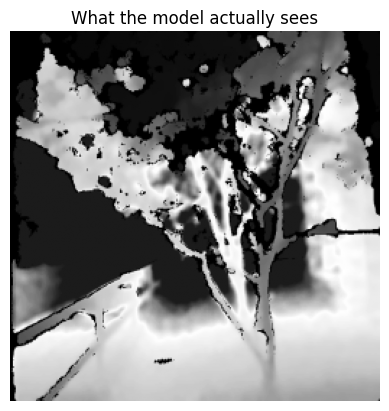

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(tensor_img, cmap='gray')
plt.title("What the model actually sees")
plt.axis('off')
plt.show()


# With Sequences

In [ ]:
frame_dir   = "/content/drive/MyDrive/AI Robotic/scenario 2"  # folder containing your PNGs
num_frames  =4                                              # how many consecutive frames
model_device = device  # assumes you've already defined `device` and loaded `model`

# --- 1) Collect & sort the first N frame paths ---
frame_paths = sorted(glob.glob(f"{frame_dir}/*.png"))[:num_frames]
if len(frame_paths) < num_frames:
    raise RuntimeError(f"Found only {len(frame_paths)} PNGs; need {num_frames}")

# --- 2) Load, preprocess, and convert each to a tensor [1, H, W] ---
frames = []
for p in frame_paths:
    img         = cv2.imread(p, cv2.IMREAD_COLOR)
    gray        = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized     = cv2.resize(gray, (256, 256), interpolation=cv2.INTER_AREA)
    normed      = resized.astype(np.float32) / 255.0
    tensor      = torch.from_numpy(normed).unsqueeze(0)  # [1, 256, 256]
    frames.append(tensor)

# --- 3) Stack into [B, T, C, H, W] = [1, num_frames, 1, 256, 256] ---
sequence = torch.stack(frames, dim=0).unsqueeze(0).to(model_device)




# --- 4) Inference ---
model.eval()
with torch.no_grad():
    logits = model(sequence)              # shape [1, num_classes]
    pred   = logits.argmax(dim=1).item()  # scalar

print(f"Predicted action for the sequence: {pred}")

Predicted action for the sequence: 0


# With time

In [ ]:
import glob
import cv2
import numpy as np
import torch
import time

# --- Helper: runs one forward‐pass and measures elapsed time ---
def infer_and_time(model, input_tensor, device):
    model.eval()
    input_tensor = input_tensor.to(device)
    # ensure all CUDA work finishes before timing
    if device.type == 'cuda':
        torch.cuda.synchronize()
    start = time.time()
    with torch.no_grad():
        logits = model(input_tensor)
    # ensure all CUDA work finishes before stopping timer
    if device.type == 'cuda':
        torch.cuda.synchronize()
    elapsed = time.time() - start
    pred    = logits.argmax(dim=1).item()
    return pred, elapsed

# --- 0) Params ---
frame_dir    = "/content/drive/MyDrive/AI Robotic/scenario 2"
num_frames   = 4
model_device = device  # assumes you've already defined `device` and loaded `model`

# --- 1) Collect & sort the first N frame paths ---
frame_paths = sorted(glob.glob(f"{frame_dir}/*.png"))[:num_frames]
if len(frame_paths) < num_frames:
    raise RuntimeError(f"Found only {len(frame_paths)} PNGs; need {num_frames}")

# --- 2) Load, preprocess, and convert each to a [1, H, W] tensor ---
frames = []
for p in frame_paths:
    img     = cv2.imread(p, cv2.IMREAD_COLOR)
    gray    = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (256, 256), interpolation=cv2.INTER_AREA)
    normed  = resized.astype(np.float32) / 255.0
    tensor  = torch.from_numpy(normed).unsqueeze(0)  # [1,256,256]
    frames.append(tensor)

# --- 3) Stack into [B, T, C, H, W] = [1, num_frames, 1, 256, 256] ---
sequence = torch.stack(frames, dim=0).unsqueeze(0).to(model_device)

# --- 4) Inference + timing ---
pred, latency = infer_and_time(model, sequence, model_device)
print(f"Predicted action: {pred}   (inference time: {latency*1000:.2f} ms)")


Predicted action: 0   (inference time: 3900.62 ms)


In [ ]:
import glob
import cv2
import numpy as np
import torch
import time

# --- Helper: runs one forward‐pass and measures elapsed time ---
def infer_and_time(model, input_tensor, device):
    model.eval()
    input_tensor = input_tensor.to(device)
    # ensure all CUDA work finishes before timing
    if device.type == 'cuda':
        torch.cuda.synchronize()
    start = time.time()
    with torch.no_grad():
        logits = model(input_tensor)
    # ensure all CUDA work finishes before stopping timer
    if device.type == 'cuda':
        torch.cuda.synchronize()
    elapsed = time.time() - start
    pred    = logits.argmax(dim=1).item()
    return pred, elapsed

# --- 0) Params ---
frame_dir    = "/content/drive/MyDrive/AI Robotic/scenario 2"
num_frames   = 4
model_device = device  # assumes you've already defined `device` and loaded `model`

# --- 1) Collect & sort the first N frame paths ---
frame_paths = sorted(glob.glob(f"{frame_dir}/*.png"))[:num_frames]
if len(frame_paths) < num_frames:
    raise RuntimeError(f"Found only {len(frame_paths)} PNGs; need {num_frames}")

# --- 2) Load, preprocess, and convert each to a [1, H, W] tensor ---
# Store these as a list of tensors
frames = []
for p in frame_paths:
    img     = cv2.imread(p, cv2.IMREAD_COLOR)
    gray    = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (256, 256), interpolation=cv2.INTER_AREA)
    normed  = resized.astype(np.float32) / 255.0
    tensor  = torch.from_numpy(normed).unsqueeze(0)  # [1,256,256]
    frames.append(tensor)

# --- 3) Iterate through frames and run inference on each ---
predictions_and_latencies = []
for i, frame_tensor in enumerate(frames):
    # Need to format each frame as [B=1, T=1, C=1, H, W]
    input_for_inference = frame_tensor.unsqueeze(0).unsqueeze(0) # [1, 1, 1, 256, 256]

    pred, latency = infer_and_time(model, input_for_inference, model_device)
    predictions_and_latencies.append((pred, latency))
    print(f"Frame {i+1}: Predicted action: {pred}   (inference time: {latency*1000:.2f} ms)")

# --- Optional: Print summary ---
print("\n--- Summary ---")
for i, (pred, latency) in enumerate(predictions_and_latencies):
    print(f"Frame {i+1}: Pred: {pred}, Latency: {latency*1000:.2f} ms")

Frame 1: Predicted action: 3   (inference time: 4364.48 ms)
Frame 2: Predicted action: 3   (inference time: 1964.90 ms)
Frame 3: Predicted action: 3   (inference time: 2028.71 ms)
Frame 4: Predicted action: 6   (inference time: 2477.45 ms)

--- Summary ---
Frame 1: Pred: 3, Latency: 4364.48 ms
Frame 2: Pred: 3, Latency: 1964.90 ms
Frame 3: Pred: 3, Latency: 2028.71 ms
Frame 4: Pred: 6, Latency: 2477.45 ms
